# AdaBoost fraction correct analysis
### Table of contents
1. [Data preprocessing](#Data-preprocessing)
2. [Fitting random forest](#Fit-random-forest-and-run-10-fold-CV-validation)
3. [Feature importance](#Feature-importance)

In [1]:
import sys
sys.path.append('/home/jbourbeau/cr-composition')
print('Added to PYTHONPATH')

Added to PYTHONPATH


In [2]:
import argparse
from collections import defaultdict
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn.apionly as sns

from sklearn.metrics import accuracy_score
from sklearn.model_selection import validation_curve, GridSearchCV, cross_val_score, ParameterGrid

import composition as comp
import composition.analysis.plotting as plotting

# Plotting-related
sns.set_palette('muted')
sns.set_color_codes()
color_dict = {'P': 'b', 'He': 'g', 'Fe': 'm', 'O': 'r'}
%matplotlib inline

/home/jbourbeau/.local/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


<a id='data_preprocessing'></a>

## Data preprocessing
1. Load simulation dataframe and apply specified quality cuts
2. Extract desired features from dataframe
3. Get separate testing and training datasets

In [3]:
df, cut_dict = comp.load_sim(return_cut_dict=True)
selection_mask = np.array([True] * len(df))
standard_cut_keys = ['lap_reco_success', 'lap_zenith', 'num_hits_1_30', 'IT_signal',
                     'StationDensity', 'max_qfrac_1_30', 'lap_containment', 'energy_range_lap']
for key in standard_cut_keys:
    selection_mask *= cut_dict[key]

df = df[selection_mask]

feature_list, feature_labels = comp.get_training_features()
print('training features = {}'.format(feature_list))
X_train, X_test, y_train, y_test, le = comp.get_train_test_sets(
    df, feature_list, train_he=True, test_he=True)

print('number training events = ' + str(y_train.shape[0]))

/home/jbourbeau/cr-composition/composition/load_sim.py:109: RuntimeWarning: divide by zero encountered in log10
  df['log_NChannels_1_30'] = np.nan_to_num(np.log10(df['NChannels_1_30']))


training features = ['lap_log_energy', 'InIce_log_charge_1_30', 'lap_cos_zenith', 'NChannels_1_30', 'log_s125', 'StationDensity']
number training events = 125085


In [ ]:
le.inverse_transform(y_train)[:50], le.inverse_transform(y_test)[:50]

## Grid search to find optimal hyperparameters

In [ ]:
pipeline = comp.get_pipeline('RF')
param_range = np.arange(1, 21)
param_grid = {'classifier__max_depth': param_range,
              'classifier__min_samples_leaf': np.arange(1, 100, 25)}
gs = GridSearchCV(estimator=pipeline,
                  param_grid=param_grid,
                  scoring='accuracy',
                  cv=5,
                  verbose=1,
                  n_jobs=20)
gs = gs.fit(X_train, y_train)
print('best GS CV score = {}'.format(gs.best_score_))
print('best GS CV depths = {}'.format(gs.best_params_))
print('Grid scores on development set:')
means = gs.cv_results_['mean_test_score']
stds = gs.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, gs.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))
pipeline.set_params(**gs.best_params_)
pipeline.fit(X_train, y_train)
scaler = pipeline.named_steps['scaler']
clf = pipeline.named_steps['classifier']

## Fit random forest and run 10-fold CV validation

In [4]:
pipeline = comp.get_pipeline('AB')
pipeline.fit(X_train, y_train)
clf_name = pipeline.named_steps['classifier'].__class__.__name__
print('=' * 30)
print(clf_name)
test_predictions = pipeline.predict(X_test)
test_acc = accuracy_score(y_test, test_predictions)
print('Test accuracy: {:.4%}'.format(test_acc))
train_predictions = pipeline.predict(X_train)
train_acc = accuracy_score(y_train, train_predictions)
print('Train accuracy: {:.4%}'.format(train_acc))
scores = cross_val_score(
    estimator=pipeline, X=X_test, y=y_test, cv=10, n_jobs=20)
print('CV score: {:.2%} (+/- {:.2%})'.format(scores.mean(), scores.std()))
print('=' * 30)

AdaBoostClassifier
Test accuracy: 41.2723%
Train accuracy: 41.5957%
CV score: 41.15% (+/- 0.41%)


In [10]:
clf = pipeline.named_steps['classifier']
decisiontree = clf.estimators_[0]
tree =  decisiontree.tree_
leaf_samples = []
for tree in clf.estimators_:
    leaf_samples.extend(tree.tree_.n_node_samples[tree.apply(X_test.astype(np.float32))])
print(np.min(leaf_samples))
print(np.max(leaf_samples))

1
8204


(0, 1000)

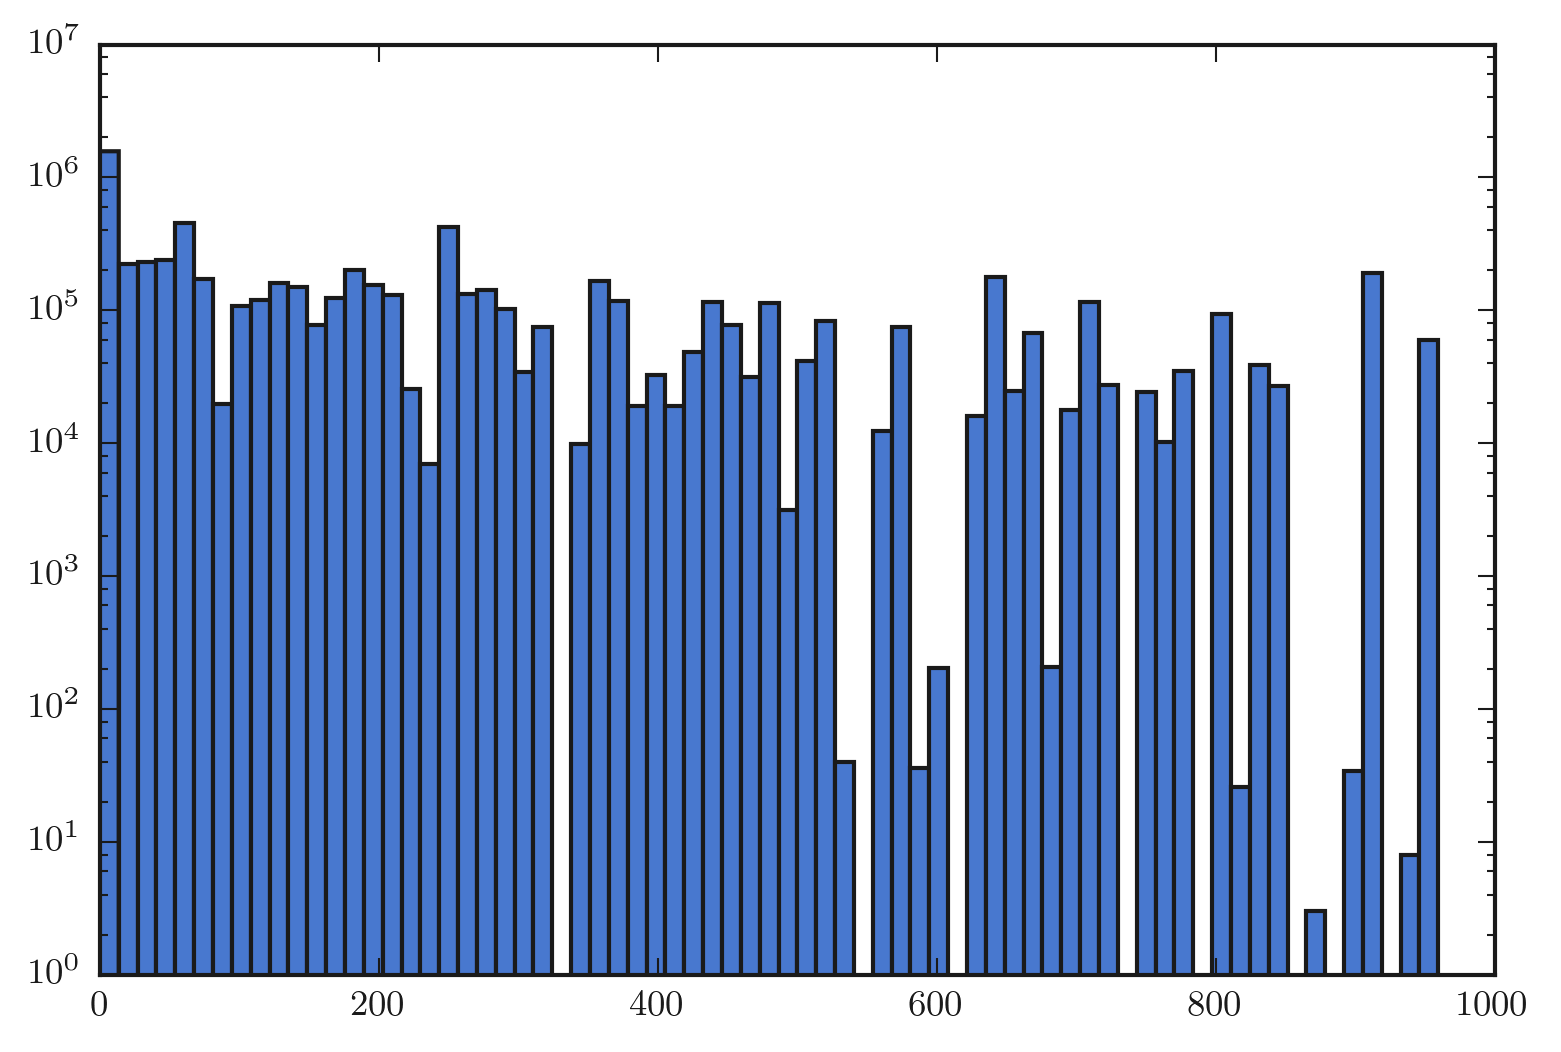

In [11]:
counts, bins, pathches = plt.hist(leaf_samples, bins=np.linspace(0, 1000, 75), log=True)
plt.xlim([0, 1000])

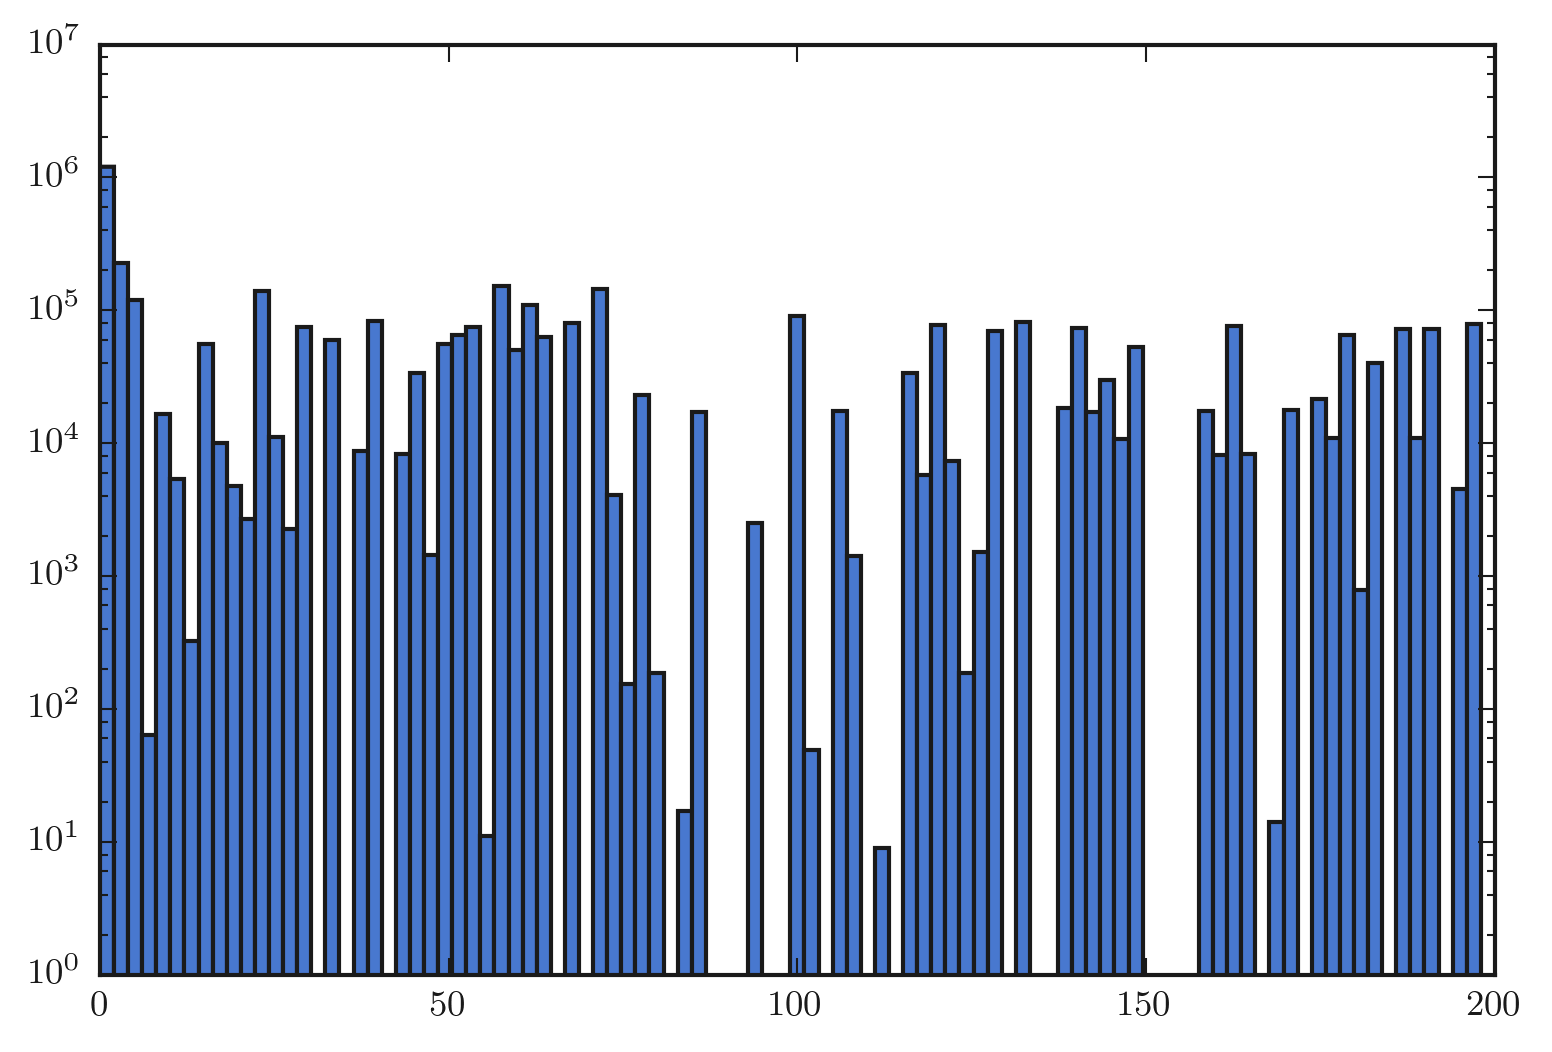

In [13]:
counts, bins, pathches = plt.hist(leaf_samples, bins=np.linspace(0, 200, 100), log=True)

In [5]:
comp_list = ['P', 'He', 'O', 'Fe']

correctly_identified_mask = (test_predictions == y_test)

# Energy-related variables
energy_bin_width = 0.1
energy_bins = np.arange(6.2, 8.1, energy_bin_width)
# energy_bins = np.arange(6.2, 9.51, energy_bin_width)
energy_midpoints = (energy_bins[1:] + energy_bins[:-1]) / 2
log_energy = X_test[:, 0]

# Construct MC composition masks
MC_comp_mask = {}
for composition in comp_list:
    MC_comp_mask[composition] = (le.inverse_transform(y_test) == composition)

# Get number of MC comp in each reco energy bin
num_MC_energy, num_MC_energy_err = {}, {}
for composition in comp_list:
    num_MC_energy[composition] = np.histogram(log_energy[MC_comp_mask[composition]],
                                     bins=energy_bins)[0]
    num_MC_energy_err[composition] = np.sqrt(num_MC_energy[composition])

num_MC_energy['total'] = np.histogram(log_energy, bins=energy_bins)[0]
num_MC_energy_err['total'] = np.sqrt(num_MC_energy['total'])


# Get number of correctly identified comp in each reco energy bin
num_reco_energy, num_reco_energy_err = {}, {}
for composition in comp_list:
    num_reco_energy[composition] = np.histogram(
        log_energy[MC_comp_mask[composition] & correctly_identified_mask],
        bins=energy_bins)[0]
    num_reco_energy_err[composition] = np.sqrt(num_reco_energy[composition])

num_reco_energy['total'] = np.histogram(log_energy[correctly_identified_mask], bins=energy_bins)[0]
num_reco_energy_err['total'] = np.sqrt(num_reco_energy['total'])



# Calculate correctly identified fractions as a function of MC energy
reco_frac, reco_frac_err = {}, {}
for composition in comp_list:
    print(composition)
    reco_frac[composition], reco_frac_err[composition] = comp.ratio_error(
        num_reco_energy[composition], num_reco_energy_err[composition],
        num_MC_energy[composition], num_MC_energy_err[composition])
    
reco_frac['total'], reco_frac_err['total'] = comp.ratio_error(
        num_reco_energy['total'], num_reco_energy_err['total'],
        num_MC_energy['total'], num_MC_energy_err['total'])

P
He
O
Fe


$\mathrm{\underline{CV \ score}}$:
41.15\% (+/- 0.41\%)


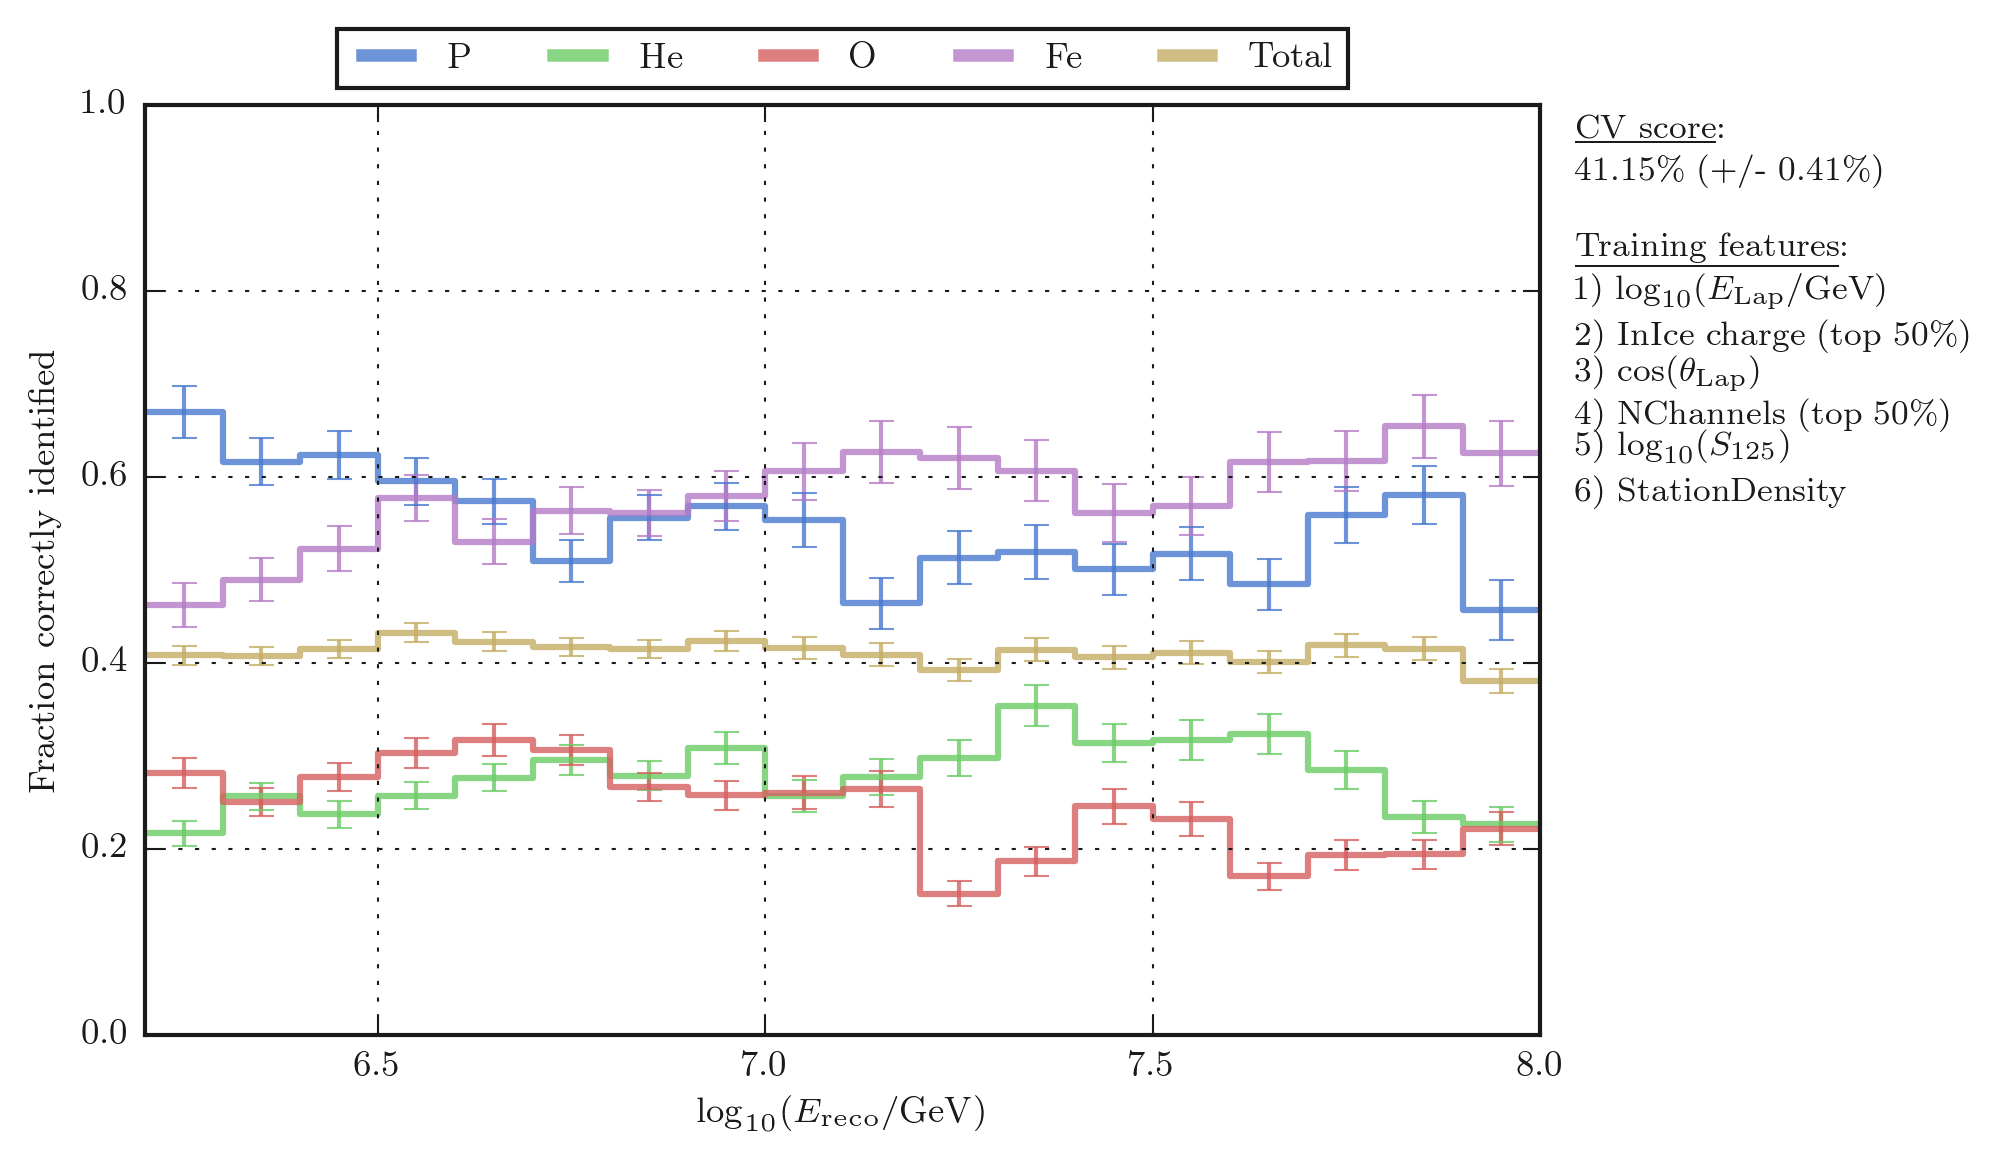

In [6]:
# Plot fraction of events vs energy
fig, ax = plt.subplots()
for composition in comp_list:
    ebar = ax.errorbar(energy_midpoints, reco_frac[composition],
                yerr=reco_frac_err[composition],
                # xerr=energy_bin_width / 2,
                marker=None, markersize=5,
#                 alpha=0.8, color=next(color_gen))
                alpha=0.8)
    step_x = energy_midpoints
    step_x = np.append(step_x[0]-energy_bin_width/2, step_x)
    step_x = np.append(step_x, step_x[-1]+energy_bin_width/2)
    step_y = reco_frac[composition]
    step_y = np.append(step_y[0], step_y)
    step_y = np.append(step_y, step_y[-1])
    ax.step(step_x, step_y, where='mid',
            marker=None, color=ebar[0].get_color(), linewidth=1.5,
            linestyle='-', label=composition, alpha=0.8)
ebar = ax.errorbar(energy_midpoints, reco_frac['total'],
                yerr=reco_frac_err['total'],
                # xerr=energy_bin_width / 2,
                marker=None, markersize=5,
                alpha=0.8)
step_y = reco_frac['total']
step_y = np.append(step_y[0], step_y)
step_y = np.append(step_y, step_y[-1])
ax.step(step_x, step_y, where='mid', marker=None,
        color=ebar[0].get_color(), linewidth=1.5, label='Total', alpha=0.8)
plt.xlabel('$\log_{10}(E_{\mathrm{reco}}/\mathrm{GeV})$')
ax.set_ylabel('Fraction correctly identified')
ax.set_ylim([0.0, 1.0])
ax.set_xlim([6.2, 8.0])
# ax.set_xlim([6.2, 9.5])
plt.grid()
leg = plt.legend(loc='upper center', 
          bbox_to_anchor=(0.5,  # horizontal
                          1.1),# vertical 
          ncol=len(comp_list)+1, fancybox=False)
# set the linewidth of each legend object
for legobj in leg.legendHandles:
    legobj.set_linewidth(3.0)
    
# place a text box in upper left in axes coords
textstr = '$\mathrm{\underline{Training \ features}}$: \n'
for i, label in enumerate(feature_labels):
    if (i == len(feature_labels)-1):
        textstr += '{}) '.format(i+1) + label
    else:
        textstr += '{}) '.format(i+1) + label + '\n'
props = dict(facecolor='white', linewidth=0)
ax.text(1.025, 0.855, textstr, transform=ax.transAxes, fontsize=8,
        verticalalignment='top', bbox=props)
cvstr = '$\mathrm{\underline{CV \ score}}$:\n' + '{:0.2f}\% (+/- {:.2}\%)'.format(scores.mean()*100, scores.std()*100)
print(cvstr)
props = dict(facecolor='white', linewidth=0)
ax.text(1.025, 0.9825, cvstr, transform=ax.transAxes, fontsize=8,
        verticalalignment='top', bbox=props)
outfile = '/home/jbourbeau/public_html/figures/composition' + \
          '/fraction-reco-correct_vs_reco-energy_RF.png'
plt.savefig(outfile)
plt.show()

    MC Compositions
P             53093
He            53210
O             51829
Fe            50343
    after
P   27219
He  16993
O   12985
Fe  26193


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f9144f4f250>], dtype=object)

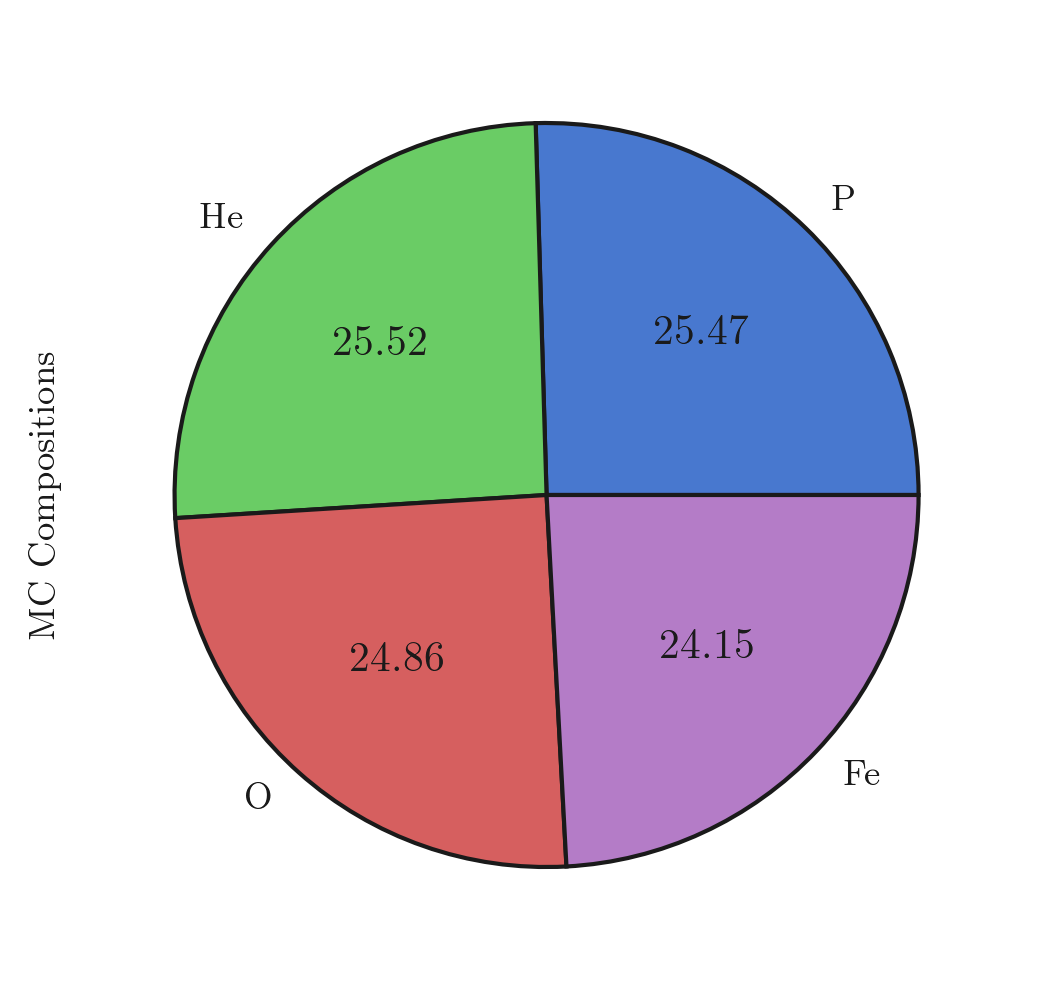

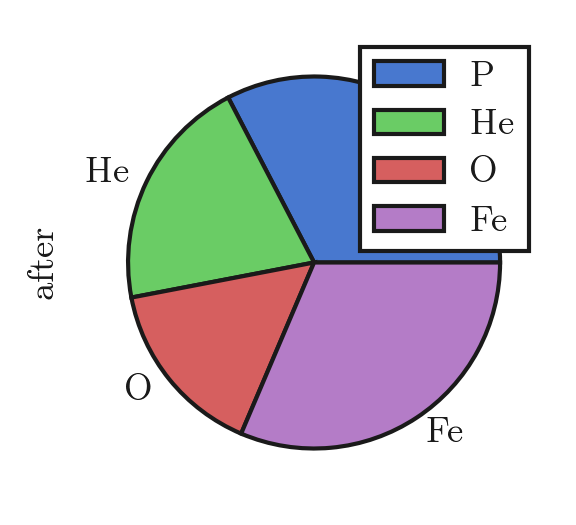

In [7]:
a = pd.DataFrame([np.sum(df.MC_comp == composition) for composition in comp_list],
                 index=comp_list, columns=['MC Compositions'])
print(a)
a.plot.pie(subplots=True, figsize=(4,4), legend=False, autopct='%.2f')
a = pd.DataFrame([np.sum(le.inverse_transform(test_predictions) == composition) for composition in comp_list], index=comp_list, columns=['after'])
print(a)
a.plot.pie(subplots=True, figsize=(2,2))

## Feature importance

1) 0.387783867673
2) 0.282746986276
3) 0.162070349702
4) 0.124910448661
5) 0.0424883476872


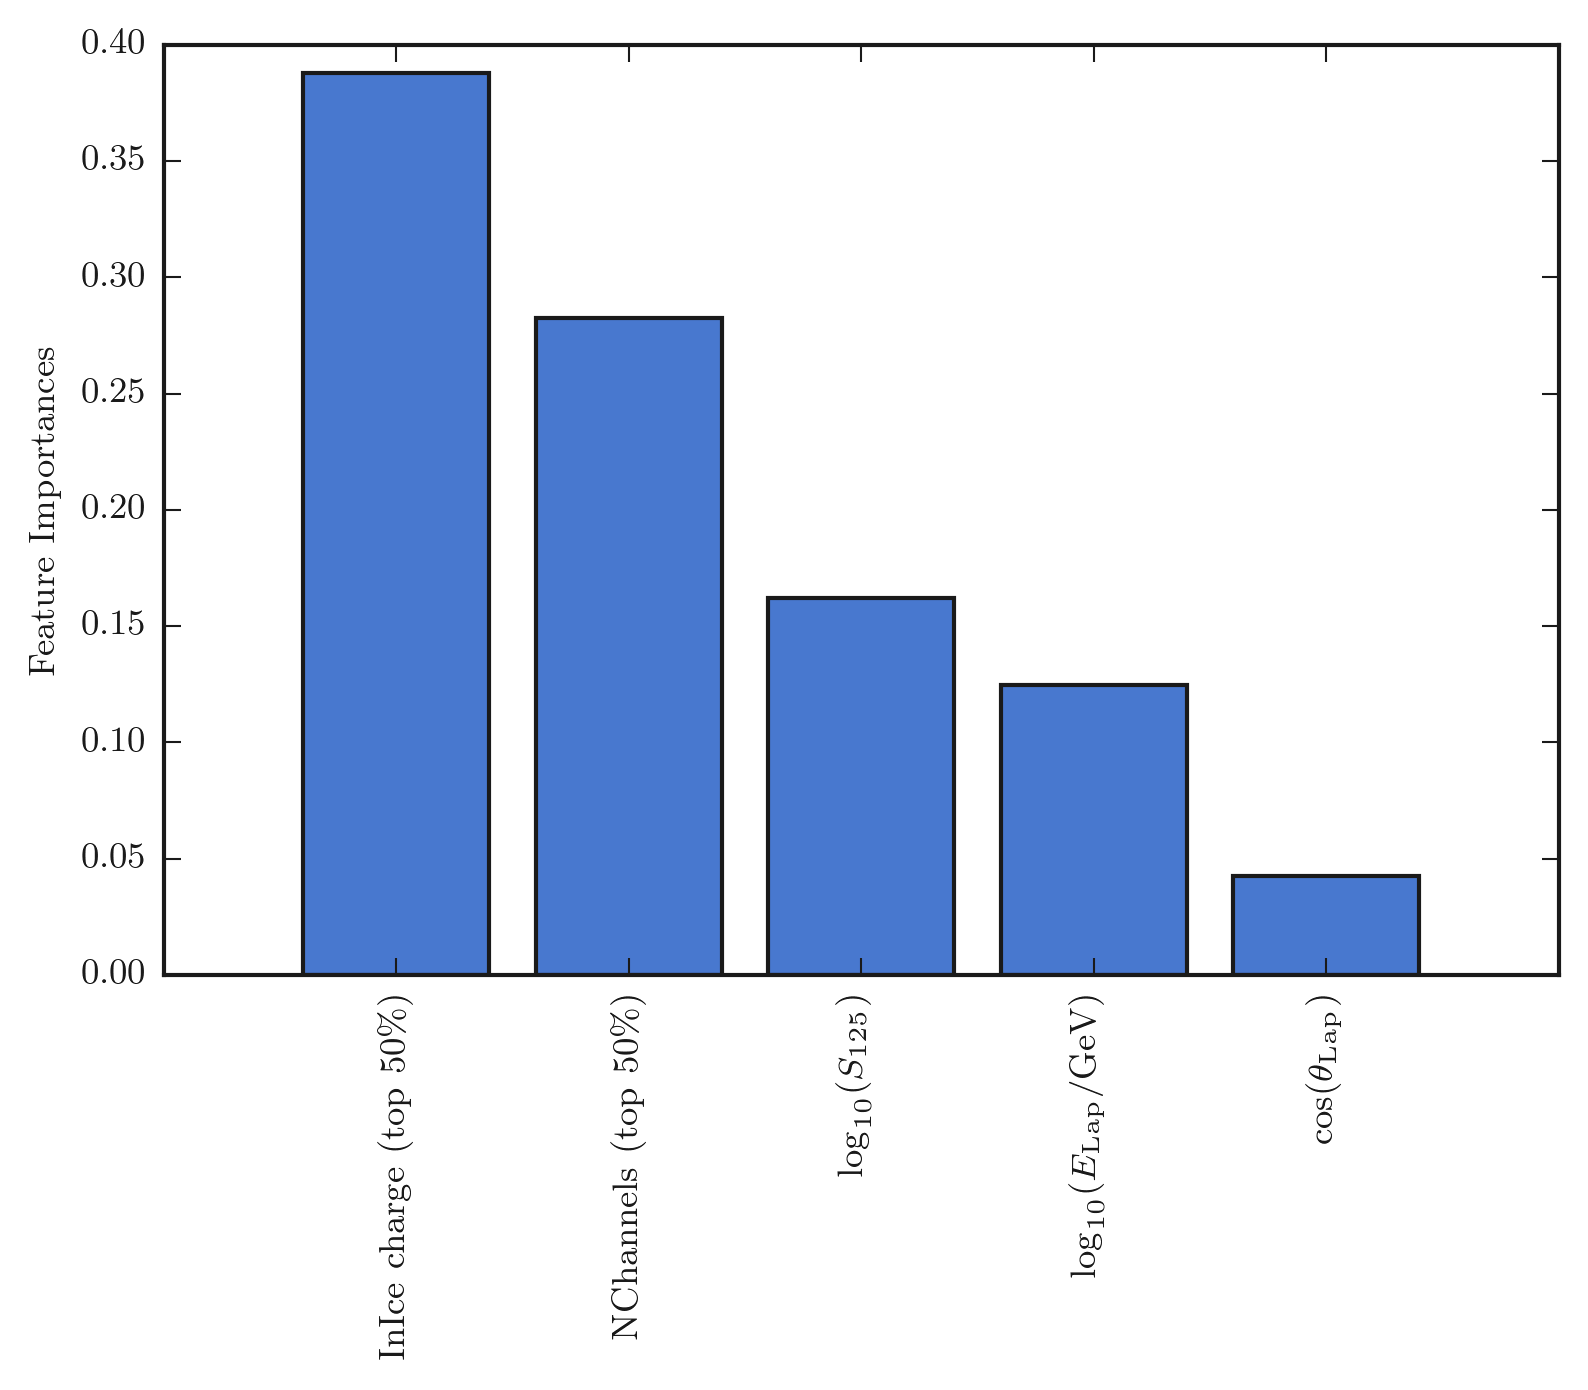

In [8]:
num_features = len(feature_list)
importances = pipeline.named_steps['classifier'].feature_importances_
indices = np.argsort(importances)[::-1]

fig, ax = plt.subplots()
for f in range(num_features):
    print('{}) {}'.format(f + 1, importances[indices[f]]))

plt.ylabel('Feature Importances')
plt.bar(range(num_features),
        importances[indices],
        align='center')

plt.xticks(range(num_features),
           feature_labels[indices], rotation=90)
plt.xlim([-1, len(feature_list)])
# plt.ylim([0, .40])
plt.show()

In [ ]:
probs = pipeline.named_steps['classifier'].predict_proba(X_test)
prob_1 = probs[:, 0][MC_iron_mask]
prob_2 = probs[:, 1][MC_iron_mask]
# print(min(prob_1-prob_2))
# print(max(prob_1-prob_2))
# plt.hist(prob_1-prob_2, bins=30, log=True)
plt.hist(prob_1, bins=np.linspace(0, 1, 50), log=True)
plt.hist(prob_2, bins=np.linspace(0, 1, 50), log=True)

In [ ]:
probs = pipeline.named_steps['classifier'].predict_proba(X_test)
dp1 = (probs[:, 0]-probs[:, 1])[MC_proton_mask]
print(min(dp1))
print(max(dp1))
dp2 = (probs[:, 0]-probs[:, 1])[MC_iron_mask]
print(min(dp2))
print(max(dp2))
fig, ax = plt.subplots()
# plt.hist(prob_1-prob_2, bins=30, log=True)
counts, edges, pathes = plt.hist(dp1, bins=np.linspace(-1, 1, 100), log=True, label='Proton', alpha=0.75)
counts, edges, pathes = plt.hist(dp2, bins=np.linspace(-1, 1, 100), log=True, label='Iron', alpha=0.75)
plt.legend(loc=2)
plt.show()
pipeline.named_steps['classifier'].classes_

In [ ]:
print(pipeline.named_steps['classifier'].classes_)
le.inverse_transform(pipeline.named_steps['classifier'].classes_)

In [ ]:
pipeline.named_steps['classifier'].decision_path(X_test)

In [ ]:
comp_list = np.unique(df['MC_comp'])
# test_probs = defaultdict(list)
fig, ax = plt.subplots()
test_probs = pipeline.predict_proba(X_test)
for class_ in pipeline.classes_:
    composition = le.inverse_transform(class_)
    plt.hist(test_probs[:, class_], bins=np.linspace(0, 1, 50),
             histtype='step', label=composition,
             color=color_dict[composition], alpha=0.8, log=True)
plt.ylabel('Counts')
plt.xlabel('Testing set class probabilities')
plt.legend()
plt.grid()
plt.show()

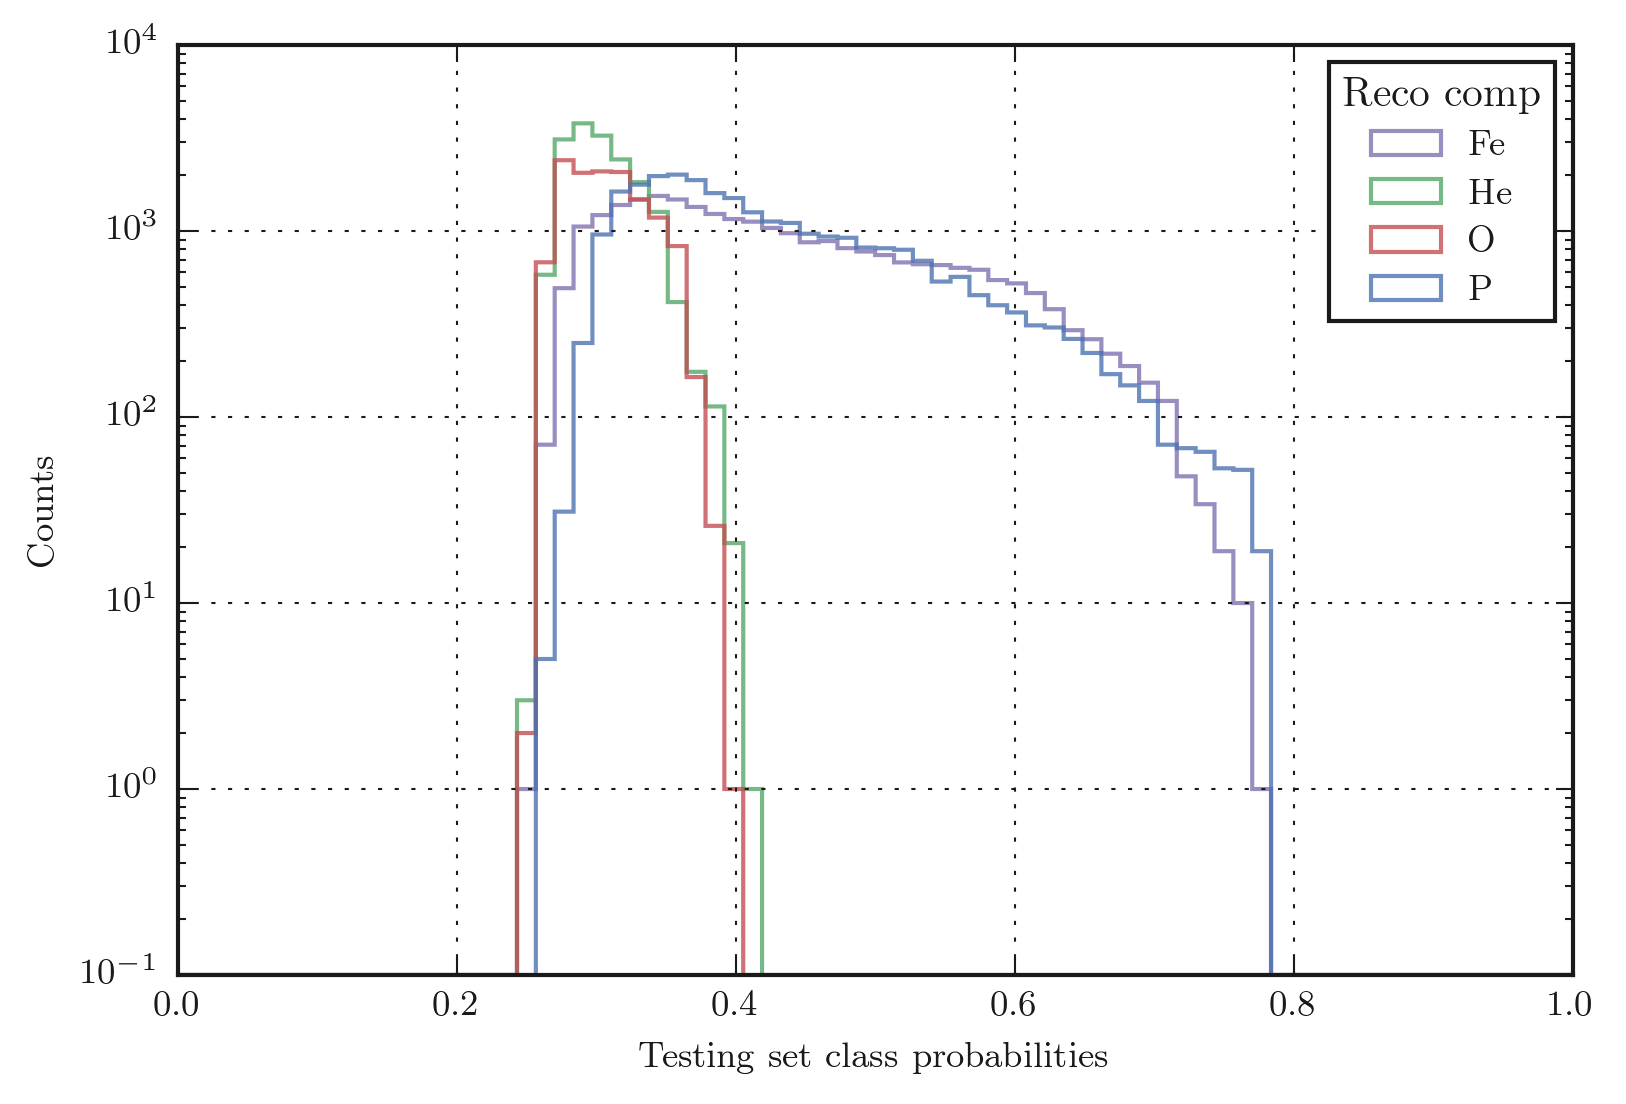

In [9]:
comp_list = np.unique(df['MC_comp'])
test_probs = defaultdict(list)
fig, ax = plt.subplots()
# test_probs = pipeline.predict_proba(X_test)
for event in pipeline.predict_proba(X_test):
    composition = le.inverse_transform(np.argmax(event))
#     print(composition)
    test_probs[composition].append(np.amax(event))
for composition in comp_list:
    plt.hist(test_probs[composition], bins=np.linspace(0, 1, 75),
             histtype='step', label=composition,
             color=color_dict[composition], alpha=0.8, log=True)
plt.ylabel('Counts')
plt.xlabel('Testing set class probabilities')
plt.legend(title='Reco comp')
plt.grid()
plt.show()